In [1]:
import numpy as np 
import pandas as pd
import hiive.mdptoolbox 
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import gym
import matplotlib.pyplot as plt
import time
from hiive.visualization.mdpviz.utils import display_mdp
from gym.envs.toy_text import frozen_lake as FL
from matplotlib import pyplot as plt
from matplotlib import colors
from hiive.mdptoolbox import mdp 
import seaborn as sns
import time

In [19]:
def draw_grid(state_map, save_loc):
    cmap = colors.ListedColormap(['Blue', 'White','Black', 'Green'])
    
    color_dict = {'S':0, 'F':1, 'H':2, 'G':3}
    data = np.reshape([color_dict[i] for v in state_map for i in v], (nx, ny))
    
    plt.figure(figsize=(6,6))
    plt.pcolor(data[::-1],cmap=cmap,edgecolors='k', linewidths=3)
    plt.axis('off')
    if save_loc:
        plt.savefig(save_loc)
    else:
        plt.show()

In [3]:
def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var, 'o-')
    plt.show()

def plot_data_legend(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    colors = ['red','orange','black','green','blue','violet']
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
#         if i == 2: # don't plot when i = 1 for cv
#             x_vars = x_vars[1:]
        plt.plot(x_vars, y_var, 'o-', color=colors[i % 6], label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend()
    plt.show()

In [4]:
def get_lake_T_R(env):

    T = np.zeros((env.nA, env.nS, env.nS))
    R = np.zeros((env.nA, env.nS, env.nS))

    for state_origin in range(env.nS):
        for action_type in range(env.nA):
            trans_list = env.P[state_origin][action_type]
            for transition_P, state_dest, reward, terminal in trans_list:
                T[action_type,state_origin,state_dest] += transition_P
                if terminal and reward == 0.0:
                    reward = -1
                R[action_type,state_origin,state_dest] = reward

            T[action_type,state_origin,:]/=np.sum(T[action_type,state_origin,:])
            
    return T, R

In [5]:
def make_time_array(run_stats, variables):
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

### Run Experiments

In [6]:
def compose_discounts(significant_digits):
    prev_discount = 0
    discounts = []
    for i in range(1,significant_digits + 1):
        discounts.append(round(prev_discount + 9*(10**-i),i))
        prev_discount = discounts[-1]
    return discounts

def forest_experiments(solver, states, discounts, epsilons, probability=0.1, max_iter=10):
    experiments = [] #num states, probability, discount, time, iterations, policy
    for s in states:
        for e in epsilons:
            for d in discounts:
                print('Running Experiment: Number of States:{0}, Epsilon:{1}, Discount:{2}'.format(s, e,d))
                entry = {}
                P, R = hiive.mdptoolbox.example.forest(S=s, p=probability)
                #start_time = time.time()
                args = {"transitions":P, "reward":R, "gamma":d, "epsilon":e, "max_iter":max_iter, "skip_check":True}
                mdp = solver(args)
                mdp.run()
                #end_time = time.time()
                entry["time"] = mdp.time
                entry["iterations"] = mdp.iter
                entry["policy"] = mdp.policy
                entry["num_states"] = s
                entry["probability"] = probability
                entry["discount"] = d
                entry["epsilon"] = e
                entry["run_stats"] = mdp.run_stats
                experiments.append(entry)
    return experiments

In [7]:
def lake_experiments(solver, states, p_frozen, probabilistic, discounts, epsilons, probability=0.1, max_iter=1000):
    experiments = [] #num states, probability, discount, time, iterations, policy
    for s in states:
        for p_freeze in p_frozen:
            for e in epsilons:
                for d in discounts:
                    entry = {}
                    nx = int(np.sqrt(s))
                    ny = nx
                    print('Running Experiment: NX:{0}, Epsilon:{1}, Discount:{2}'.format(nx,e,d))
                    ## Generate a Random Lake
                    random_map = FL.generate_random_map(size=nx, p=p_freeze)
                    env = FL.FrozenLakeEnv(desc=random_map, is_slippery = probabilistic)
                    T, R = get_lake_T_R(env)

                    args = {"transitions":T, "reward":R, "gamma":d, "epsilon":e, "max_iter":max_iter, "skip_check":True}
                    mdp = solver(args)
                    #mdp.run()

                    entry["nx"] = nx
                    entry["time"] = mdp.time
                    entry["iterations"] = mdp.iter
                    entry["policy"] = mdp.policy
                    entry["num_states"] = s
                    entry["probability"] = probability
                    entry["discount"] = d
                    entry["epsilon"] = e
                    entry["p_freeze"] = p_freeze
                    entry["run_stats"] = mdp.run_stats
                    experiments.append(entry)
    return experiments

In [8]:
def fm_q_experiments(states, gammas, alphas, alpha_decays, alpha_mins,
                     epsilons, epsilon_mins,epsilon_decays, 
                     probability=0.1,max_iter=100000):
    experiments = []
    for s in states:
        for gamma in gammas:
            for alpha in alphas:
                for alpha_decay in alpha_decays:
                    for alpha_min in alpha_mins:
                        for epsilon in epsilons:
                            for epsilon_min in epsilon_mins:
                                for epsilon_decay in epsilon_decays:
                                    entry = {}
                                    print('Running Experiment: S:{0}'.format(s))
                                    ## Generate a Random Lake
                                    P, R = hiive.mdptoolbox.example.forest(S=s, p=probability)
                                    q_solve = mdp.QLearning(P, R, gamma = gamma, alpha=alpha, alpha_decay=alpha_decay, alpha_min=alpha_min,
                                                            epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                                                            n_iter=max_iter,  skip_check=True)
                                    q_solve.run()

                                    entry["time"] = q_solve.time
                                    entry["policy"] = q_solve.policy
                                    entry["num_states"] = s
                                    entry["probability"] = probability
                                    entry["epsilon"] = epsilon
                                    entry["epsilon Min"] = epsilon_min
                                    entry["epsilon Decay"] = epsilon_decay
                                    entry["Gamma"] = gamma
                                    entry["Alpha"] = alpha
                                    entry["Alpha Decay"] = alpha_decay
                                    entry["Alpha Min"] = alpha_min
                                    entry["run_stats"] = q_solve.run_stats
                                    experiments.append(entry)
    return experiments

In [9]:
def lake_q_experiments(states, p_frozen, probabilistic, gammas, alphas,
                       alpha_decays, alpha_mins, epsilons, epsilon_mins,
                       epsilon_decays, probability=0.1,max_iter=100000):
    experiments = []
    for s in states:
        for p_freeze in p_frozen:
            for gamma in gammas:
                for alpha in alphas:
                    for alpha_decay in alpha_decays:
                        for alpha_min in alpha_mins:
                            for epsilon in epsilons:
                                for epsilon_min in epsilon_mins:
                                    for epsilon_decay in epsilon_decays:
                                        entry = {}
                                        nx = int(np.sqrt(s))
                                        ny = nx
                                        print('Running Experiment: NX:{0}'.format(nx))
                                        ## Generate a Random Lake
                                        random_map = FL.generate_random_map(size=nx, p=p_freeze)
                                        env = FL.FrozenLakeEnv(desc=random_map, is_slippery = probabilistic)
                                        T, R = get_lake_T_R(env)
                                        q_solve = mdp.QLearning(T, R, gamma = gamma, alpha=alpha, alpha_decay=alpha_decay, alpha_min=alpha_min,
                                                                epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                                                                n_iter=max_iter,  skip_check=True)
                                        q_solve.run()
                                        
                                        entry["nx"] = nx
                                        entry["time"] = q_solve.time
                                        entry["policy"] = q_solve.policy
                                        entry["num_states"] = s
                                        entry["probability"] = probability
                                        entry["P Frozen"] = p_freeze
                                        entry["epsilon"] = epsilon
                                        entry["epsilon Min"] = epsilon_min
                                        entry["epsilon Decay"] = epsilon_decay
                                        entry["Gamma"] = gamma
                                        entry["Alpha"] = alpha
                                        entry["Alpha Decay"] = alpha_decay
                                        entry["Alpha Min"] = alpha_min
                                        entry["run_stats"] = q_solve.run_stats
                                        experiments.append(entry)
    return experiments

In [10]:
import os

filename = 'fm_policy_iteration_results.npy'
if os.path.isfile(filename):
    fm_policy_iteration_results = np.load(filename, allow_pickle=True)
else:
    states = [10**s for s in range(1,5)]
    discounts = compose_discounts(3)
    epsilons = [0.01, 0.005, 0.001]

    fm_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
    fm_policy_iteration_results = forest_experiments(fm_policy_iteration, states, discounts, epsilons)

In [11]:
filename = 'fm_value_iteration_results.npy'
if os.path.isfile(filename):
    fm_value_iteration_results = np.load(filename, allow_pickle=True)
else:
    states = [10**s for s in range(1,5)]
    discounts = compose_discounts(5)
    epsilons = [0.01, 0.005, 0.001]

    fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
    fm_value_iteration_results = forest_experiments(fm_value_iteration, states, discounts, epsilons)

In [12]:
filename = 'fm_q_results.npy'
if os.path.isfile(filename):
    fm_q_results = np.load(filename, allow_pickle=True)
else:
    states = [10**s for s in [1,2,3]]
    gammas = [0.75, 0.9]
    alphas = [0.75, 0.99]
    alpha_decays = [0.9,0.99]
    alpha_mins = [0.1]
    epsilons = [0.01, 0.001]
    epsilon_mins = [0.1]
    epsilon_decays= [0.9,0.99]

    fm_q_results = fm_q_experiments(states, gammas, alphas, alpha_decays, alpha_mins,
                                        epsilons, epsilon_mins,epsilon_decays,
                                        probability=0.1,max_iter=100000)
    np.save('fm_q_results.npy', fm_q_results, allow_pickle = True)

In [13]:
filename = 'lake_policy_iteration_results.npy'
if os.path.isfile(filename):
    lake_policy_iteration_results = np.load(filename, allow_pickle=True)
else:
    states = [10**s for s in range(1,5)]
    p_frozen = [0.7, 0.8, 0.9]
    probabilistic = [True]
    discounts = compose_discounts(3)
    epsilons = [0.01, 0.005, 0.001]

    lake_policy_iteration = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIterationModified(**dict_args)
    lake_policy_iteration_results = lake_experiments(lake_policy_iteration, states, p_frozen, probabilistic, discounts, epsilons)

In [14]:
filename = 'lake_value_iteration_results.npy'
if os.path.isfile(filename):
    lake_value_iteration_results = np.load(filename, allow_pickle=True)
else:
    states = [10**s for s in range(1,5)]
    discounts = compose_discounts(5)
    epsilons = [0.01, 0.005, 0.001]

    lake_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
    lake_value_iteration_results = lake_experiments(lake_value_iteration, states, p_frozen, probabilistic, discounts, epsilons)

In [15]:
filename = 'lake_q_results.npy'
if os.path.isfile(filename):
    lake_q_results = np.load(filename, allow_pickle=True)
else:
    states = [10**s for s in [1,2,3]]
    gammas = [0.75, 0.9]
    alphas = [0.75, 0.99]
    alpha_decays = [0.9,0.99]
    alpha_mins = [0.1]
    epsilons = [0.01, 0.001]
    epsilon_mins = [0.1]
    epsilon_decays= [0.9,0.99]

    lake_q_results = lake_q_experiments(states, p_frozen, probabilistic, gammas, alphas, alpha_decays, alpha_mins,
                                        epsilons, epsilon_mins,epsilon_decays,probability=0.1,max_iter=100000)

In [16]:
def get_q_learning_df(results):
    maxV = []
    meanV = []
    times = []
    nStates = []
    eps = []
    eps_min = []
    eps_decay = []
    alphas = []
    alpha_decays = []
    alpha_mins = []
    iters = []
    v_mean_profile = []
    v_max_profile = []
    for row in results:
        maxV.append(row['run_stats'][-1]['Max V'])
        meanV.append(row['run_stats'][-1]['Mean V'])
        iters.append(row['run_stats'][-1]['Iteration'])
        times.append(row['time'])
        nStates.append(row['num_states'])
        eps.append(row['epsilon'])
        eps_min.append(row['epsilon Min'])
        eps_decay.append(row['epsilon Decay'])
        alphas.append(row['Alpha'])
        alpha_decays.append(row['Alpha Decay'])
        alpha_mins.append(row['Alpha Min'])
        v_mean_profile.append([r['Mean V'] for r in row['run_stats']])
        v_max_profile.append([r['Max V'] for r in row['run_stats']])

    df = pd.DataFrame()
    df['Max. V'] = maxV
    df['Mean V'] = meanV
    df['Total Iterations'] = iters
    df['Run Time'] = times
    df['Number of States'] = nStates
    df['Epsilon'] = eps
    df['Min. Epsilon'] = eps_min
    df['Epsilon Decay'] = eps_decay
    df['Alpha'] = alphas
    df['Alpha Decay'] = alpha_decays
    df['Min. Alpha'] = alpha_mins
    df['Mean V (Iters)'] = v_mean_profile
    df['Max. V (Iters)'] = v_max_profile
    df['Method'] = 'Q Learning'

    return df

In [ ]:
def get_val_iter_df(results):
    maxV = []
    meanV = []
    times = []
    nStates = []
    eps = []
    alphas = []
    iters = []
    v_mean_profile = []
    v_max_profile = []
    
    for row in results:
        maxV.append(row['run_stats'][-1]['Max V'])
        meanV.append(row['run_stats'][-1]['Mean V'])
        iters.append(row['run_stats'][-1]['Iteration'])
        times.append(row['time'])
        nStates.append(row['num_states'])
        eps.append(row['epsilon'])
        discounts.append(row['discount'])


    df = pd.DataFrame()
    df['Max. V'] = maxV
    df['Mean V'] = meanV
    df['Total Iterations'] = iters
    df['Run Time'] = times
    df['Number of States'] = nStates
    df['Epsilon'] = eps
    df['Method'] = 'Value Iteration'

    return df

In [360]:
lake_value_iteration_results[0]

{'nx': 3,
 'time': None,
 'iterations': 0,
 'policy': None,
 'num_states': 10,
 'probability': 0.1,
 'discount': 0.9,
 'epsilon': 0.01,
 'p_freeze': 0.7,
 'run_stats': None}

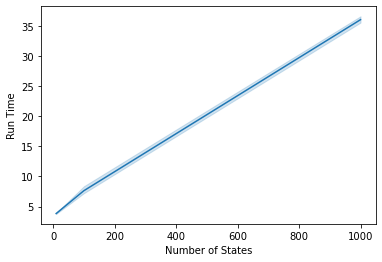

In [355]:
#lake_q_size_df = get_q_learning_df(lake_q_results)
lake_q_size_df.head()
sns.lineplot(data = lake_q_size_df, x ='Number of States', y = 'Run Time')
plt.savefig('lake_sens_s_vs_time.png')

## Main Scenarios - Frozen Lake

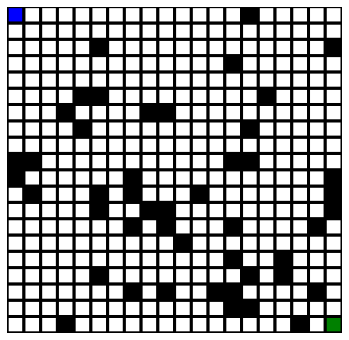

In [29]:
nx = 20
ny = nx
p_frozen = 0.9

probabilistic = True

actions = {0:'Left', 1:'Down',2:'Right',3:'Up'}

random_map = FL.generate_random_map(size=nx, p=p_frozen)
np.save('random_map_90.npy', random_map, allow_pickle=True)

env = FL.FrozenLakeEnv(desc=random_map, is_slippery = probabilistic)
draw_grid(random_map, 'frozen_lake_case')

In [30]:
T = np.zeros((env.nA, env.nS, env.nS))
R = np.zeros((env.nA, env.nS, env.nS))

for state_origin in range(env.nS):
    for action_type in range(env.nA):
        trans_list = env.P[state_origin][action_type]
        for transition_P, state_dest, reward, terminal in trans_list:
            T[action_type,state_origin,state_dest] += transition_P
            if terminal and reward == 0.0:
                reward = -1
            R[action_type,state_origin,state_dest] = reward
            
        T[action_type,state_origin,:]/=np.sum(T[action_type,state_origin,:])

In [90]:
val_iters = []

for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    for epsilon in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]:
        print('Running Gamma: {0}, Epsilon:{1}'.format(gamma, epsilon))
        val_iter = mdp.ValueIteration(T, R, gamma=gamma, epsilon=epsilon, max_iter=1000, initial_value=0, skip_check=False)
        val_iter.run()
        val_iters.append(val_iter)

Running Gamma: 0.1, Epsilon:0.0001
Running Gamma: 0.1, Epsilon:0.001
Running Gamma: 0.1, Epsilon:0.01
Running Gamma: 0.1, Epsilon:0.1
Running Gamma: 0.1, Epsilon:0.2
Running Gamma: 0.1, Epsilon:0.3
Running Gamma: 0.2, Epsilon:0.0001
Running Gamma: 0.2, Epsilon:0.001
Running Gamma: 0.2, Epsilon:0.01
Running Gamma: 0.2, Epsilon:0.1
Running Gamma: 0.2, Epsilon:0.2
Running Gamma: 0.2, Epsilon:0.3
Running Gamma: 0.3, Epsilon:0.0001
Running Gamma: 0.3, Epsilon:0.001
Running Gamma: 0.3, Epsilon:0.01
Running Gamma: 0.3, Epsilon:0.1
Running Gamma: 0.3, Epsilon:0.2
Running Gamma: 0.3, Epsilon:0.3
Running Gamma: 0.4, Epsilon:0.0001
Running Gamma: 0.4, Epsilon:0.001
Running Gamma: 0.4, Epsilon:0.01
Running Gamma: 0.4, Epsilon:0.1
Running Gamma: 0.4, Epsilon:0.2
Running Gamma: 0.4, Epsilon:0.3
Running Gamma: 0.5, Epsilon:0.0001
Running Gamma: 0.5, Epsilon:0.001
Running Gamma: 0.5, Epsilon:0.01
Running Gamma: 0.5, Epsilon:0.1
Running Gamma: 0.5, Epsilon:0.2
Running Gamma: 0.5, Epsilon:0.3
Running Ga

In [188]:
def get_val_iter_runs(val_iters):
    mean_error = []
    policy = []
    maxV = []
    meanV = []
    iters = []
    epsilons = []
    gammas = []
    error = []
    iterations = []
    times = []
    for val_iter in val_iters:
        mean_error.append(val_iter.error_mean[0])
        policy.append(val_iter.policy)
        maxV.append([row['Max V'] for row in val_iter.run_stats])
        meanV.append([row['Mean V'] for row in val_iter.run_stats])
        error.append([row['Error'] for row in val_iter.run_stats])
        iterations.append([row['Iteration'] for row in val_iter.run_stats])
        iters.append(val_iter.iter)
        epsilons.append(val_iter.epsilon)
        gammas.append(val_iter.gamma)
        times.append(val_iter.time)
        
    df = pd.DataFrame()
    df['Mean Error'] = mean_error
    df['Policy'] = policy
    df['Max Value'] = maxV
    df['Mean Value'] = meanV
    df['Number of Iterations'] = iters
    df['Epsilon'] = epsilons
    df['Gamma'] = gammas
    df['Error'] = error
    df['Iterations'] = iterations
    df['Run Time'] = times
    return df

In [334]:
df_val_iter_lake = get_val_iter_runs(val_iters)
df_val_iter_lake.head()
df_val_iter_lake.to_csv('lake_main_val_iter.csv')

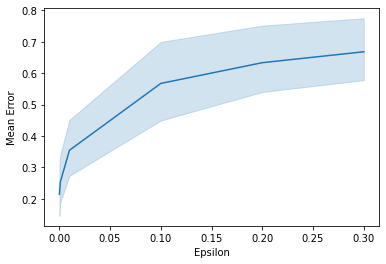

In [335]:
#plt.plot(df['Iterations'].values[0], df['Error'].values[0])
sns.lineplot(data = df_val_iter_lake, x ='Epsilon', y = 'Mean Error')
plt.savefig('lake_val_iter_eps_error.png')

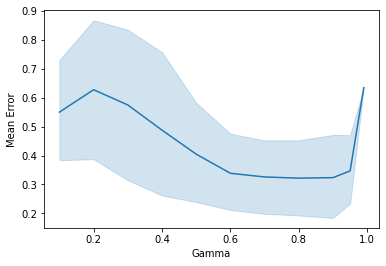

In [336]:
sns.lineplot(data = df_val_iter_lake, x ='Gamma', y = 'Mean Error')
plt.savefig('lake_val_iter_gamma_error.png')

In [387]:
lake_val_iter_eps = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Epsilon'].values[0]
lake_val_iter_gamma = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Gamma'].values[0]
lake_val_iter_policy = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Policy']
lake_val_iter_mean_value = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Mean Value']
lake_val_iter_max_value = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Max Value']
lake_val_iter_time = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Run Time'].values[0]
lake_val_iter_iters = df_val_iter_lake[df_val_iter_lake['Mean Error'] == df_val_iter_lake['Mean Error'].min()]['Number of Iterations'].values[0]

print('Lake Value Iteration Optimal Model Epsilon:{0}, Gamma:{1}'.format(lake_val_iter_eps, lake_val_iter_gamma))

Lake Value Iteration Optimal Model Epsilon:0.0001, Gamma:0.9


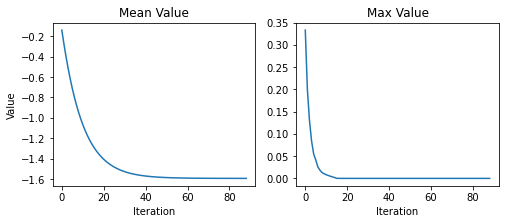

In [338]:
fig = plt.figure(figsize=(8, 3))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(lake_val_iter_mean_value.values[0], label = 'Mean Value')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean Value')

plt.subplot(1, 2, 2)
plt.plot(lake_val_iter_max_value.values[0], label = 'Max Value')
plt.xlabel('Iteration')

plt.title('Max Value')

plt.savefig('lake_val_iter_value.png')

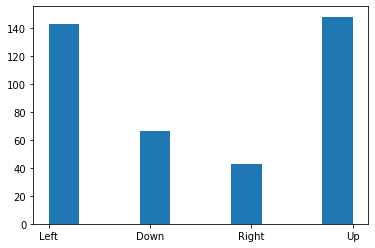

In [124]:
plt.hist(lake_val_iter_policy)
ax = plt.gca()
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Left', 'Down', 'Right', 'Up'])
plt.savefig('lake_val_iter_policy.png')

## Lake - Policy Iteration

In [141]:
pol_iters = []

for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    print('Running Gamma: {0}'.format(gamma))
    pol_iter = mdp.ValueIteration(T, R, gamma=gamma, skip_check=False)
    pol_iter.run()
    pol_iters.append(val_iter)

Running Gamma: 0.1
Running Gamma: 0.2
Running Gamma: 0.3
Running Gamma: 0.4
Running Gamma: 0.5
Running Gamma: 0.6
Running Gamma: 0.7
Running Gamma: 0.8
Running Gamma: 0.9
Running Gamma: 0.95
Running Gamma: 0.99


In [195]:
def get_pol_iter_runs(pol_iters):
    mean_error = []
    policy = []
    maxV = []
    meanV = []
    iters = []
    epsilons = []
    gammas = []
    error = []
    iterations = []
    times = []
    
    for pol_iter in pol_iters:
        mean_error.append(pol_iter.error_mean[0])
        policy.append(pol_iter.policy)
        maxV.append([row['Max V'] for row in pol_iter.run_stats])
        meanV.append([row['Mean V'] for row in pol_iter.run_stats])
        error.append([row['Error'] for row in pol_iter.run_stats])
        iterations.append([row['Iteration'] for row in pol_iter.run_stats])
        iters.append(pol_iter.iter)
        gammas.append(pol_iter.gamma)
        times.append(pol_iter.time)
        
    df = pd.DataFrame()
    df['Mean Error'] = mean_error
    df['Policy'] = policy
    df['Max Value'] = maxV
    df['Mean Value'] = meanV
    df['Number of Iterations'] = iters
    df['Gamma'] = gammas
    df['Error'] = error
    df['Iterations'] = iterations
    df['Run Time'] = times
    
    return df

In [389]:
df_pol_lake = get_pol_iter_runs(pol_iters)
df_pol_lake.to_csv('lake_pol_iter.csv')

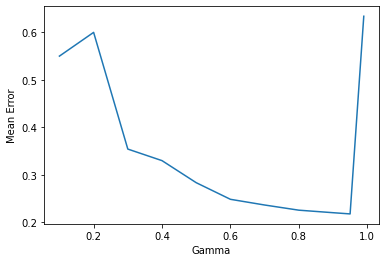

In [390]:
sns.lineplot(data = df_pol_lake, x ='Gamma', y = 'Mean Error')
plt.savefig('lake_pol_iter_gamma_error.png')

In [391]:
lake_pol_iter_gamma = df_pol_lake[df_pol_lake['Mean Error'] == df_pol_lake['Mean Error'].min()]['Gamma'].values[0]
lake_pol_iter_policy = df_pol_lake[df_pol_lake['Mean Error'] == df_pol_lake['Mean Error'].min()]['Policy']

lake_pol_iter_mean_value = df_pol_lake[df_pol_lake['Mean Error'] == df_pol_lake['Mean Error'].min()]['Mean Value']
lake_pol_iter_max_value = df_pol_lake[df_pol_lake['Mean Error'] == df_pol_lake['Mean Error'].min()]['Max Value']

lake_pol_iter_time = df_pol_lake[df_pol_lake['Mean Error'] == df_pol_lake['Mean Error'].min()]['Run Time'].values[0]
lake_pol_iter_iters = df_pol_lake[df_pol_lake['Mean Error'] == df_pol_lake['Mean Error'].min()]['Number of Iterations'].values[0]

print('Lake Policy Iteration Optimal Model Gamma:{0}'.format(lake_pol_iter_gamma))

Lake Policy Iteration Optimal Model Gamma:0.95


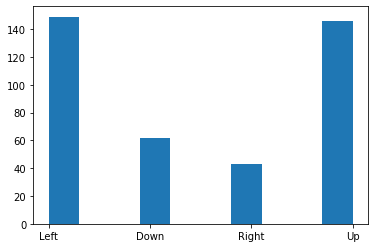

In [332]:
plt.hist(lake_pol_iter_policy)
ax = plt.gca()
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['Left', 'Down', 'Right', 'Up'])
plt.savefig('lake_pol_iter_policy_hist.png')

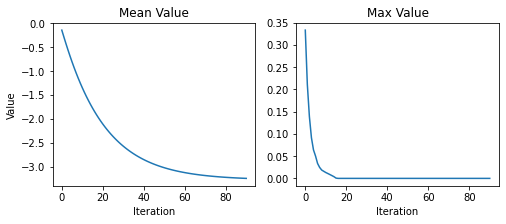

In [333]:
fig = plt.figure(figsize=(8, 3))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(lake_pol_iter_mean_value.values[0], label = 'Mean Value')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean Value')

plt.subplot(1, 2, 2)
plt.plot(lake_pol_iter_max_value.values[0], label = 'Max Value')
plt.xlabel('Iteration')

plt.title('Max Value')

plt.savefig('lake_pol_iter_value.png')

## Lake - Q Learning

In [160]:
gammas = [0.9, 0.95, 0.99]
alphas = [0.01, 0.1, 0.2]
alpha_decays = [0.75, 0.9, 0.99]
epsilons = [0.9, 0.99, 1]
epsilon_decays= [0.75, 0.9, 0.99]

n = len(gammas) * len(alphas) * len(alpha_decays)*len(epsilons)*len(epsilon_decays)
q_solvers = []

for gamma in gammas:
    for alpha in alphas:
        for alpha_decay in alpha_decays:
            for epsilon in epsilons:
                for epsilon_decay in epsilon_decays:
                    print('{0}/{1}'.format(len(q_solvers),n))
                    q_solve = mdp.QLearning(T, R, gamma = gamma, alpha=alpha, alpha_decay=alpha_decay,
                                            epsilon=epsilon, epsilon_decay=epsilon_decay,  skip_check=True)
                    q_solve.run()
                    q_solvers.append(q_solve)
                            

0/243
1/243
2/243
3/243
4/243
5/243
6/243
7/243
8/243
9/243
10/243
11/243
12/243
13/243
14/243
15/243
16/243
17/243
18/243
19/243
20/243
21/243
22/243
23/243
24/243
25/243
26/243
27/243
28/243
29/243
30/243
31/243
32/243
33/243
34/243
35/243
36/243
37/243
38/243
39/243
40/243
41/243
42/243
43/243
44/243
45/243
46/243
47/243
48/243
49/243
50/243
51/243
52/243
53/243
54/243
55/243
56/243
57/243
58/243
59/243
60/243
61/243
62/243
63/243
64/243
65/243
66/243
67/243
68/243
69/243
70/243
71/243
72/243
73/243
74/243
75/243
76/243
77/243
78/243
79/243
80/243
81/243
82/243
83/243
84/243
85/243
86/243
87/243
88/243
89/243
90/243
91/243
92/243
93/243
94/243
95/243
96/243
97/243
98/243
99/243
100/243
101/243
102/243
103/243
104/243
105/243
106/243
107/243
108/243
109/243
110/243
111/243
112/243
113/243
114/243
115/243
116/243
117/243
118/243
119/243
120/243
121/243
122/243
123/243
124/243
125/243
126/243
127/243
128/243
129/243
130/243
131/243
132/243
133/243
134/243
135/243
136/243
137/243
138/24

In [245]:
def get_q_runs(q_runs):
    actions = []
    mean_error = []
    policy = []
    maxV = []
    meanV = []
    iters = []
    epsilons = []
    gammas = []
    error = []
    iterations = []
    alphas = []
    alpha_decays = []
    epsilon_decays = []
    times = []
    
    for q_run in q_runs:
        mean_error.append(q_run.error_mean[0])
        policy.append(q_run.policy)
        actions.append([row['Action'] for row in q_run.run_stats])
        maxV.append([row['Max V'] for row in q_run.run_stats])
        meanV.append([row['Mean V'] for row in q_run.run_stats])
        error.append([row['Error'] for row in q_run.run_stats])
        iterations.append([row['Iteration'] for row in q_run.run_stats])
        epsilons.append(q_run.run_stats[0]['Epsilon'])
        gammas.append(q_run.gamma)
        times.append(q_run.time)
        alphas.append(q_run.run_stats[0]['Alpha'])
        alpha_decays.append(q_run.alpha_decay)
        epsilon_decays.append(q_run.epsilon_decay)
        
    df = pd.DataFrame()
    df['Mean Error'] = mean_error
    df['Policy'] = policy
    df['Max Value'] = maxV
    df['Mean Value'] = meanV
    df['Epsilon'] = epsilons
    df['Gamma'] = gammas
    df['Error'] = error
    df['Run Time'] = times
    df['Alpha'] = alphas
    df['Alpha Decay'] = alpha_decays
    df['Epsilon Decay'] = epsilon_decays
    
    return df

In [180]:
lake_q_df = get_q_runs(q_solvers)
lake_q_df.to_csv('lake_q_main.csv')

In [212]:
lake_q_df.head()

,Mean Error,Policy,Max Value,Mean Value,Epsilon,Gamma,Error,Run Time,Alpha,Alpha Decay,Epsilon Decay
0,0.000000,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.808224,0.001,0.75,0.75
1,0.001104,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.3370971...",0.1,0.9,"[0.0, 0.0, 0.005625, 0.00421875, 0.0031640625,...",1.720495,0.001,0.75,0.90
2,0.000550,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.822629,0.001,0.75,0.99
3,0.000809,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.689210,0.001,0.75,0.75
4,0.000000,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1,0.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.490014,0.001,0.75,0.90


In [392]:
lake_q_gamma = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Gamma'].values[0]
lake_q_eps = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Epsilon'].values[0]
lake_q_eps_decay = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Epsilon Decay'].values[0]
lake_q_alpha = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Alpha'].values[0]
lake_q_alpha_decay = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Alpha Decay'].values[0]

lake_q_policy = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Policy']
lake_q_mean_value = fm_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Mean Value']
lake_q_max_value = fm_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Max Value']
lake_q_policy = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Policy']

lake_q_time = lake_q_df[lake_q_df['Mean Error'] == lake_q_df['Mean Error'].min()]['Run Time'].values[0]
lake_q_iters = len(lake_q_max_value.values[0])

print('Lake Q Learning Optimal Model Gamma:{0}, Epsilon:{1}, Eps. Decay:{2}, Alpha:{3}, Alpha Decay:{4}'.format(lake_q_gamma, lake_q_eps, lake_q_eps_decay, lake_q_alpha, lake_q_alpha_decay))


Lake Q Learning Optimal Model Gamma:0.9, Epsilon:0.1, Eps. Decay:0.75, Alpha:0.001, Alpha Decay:0.75


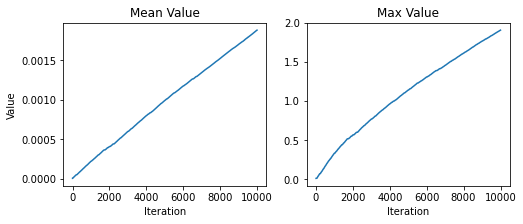

In [330]:
fig = plt.figure(figsize=(8, 3))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(lake_q_mean_value.values[0], label = 'Mean Value')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean Value')

plt.subplot(1, 2, 2)
plt.plot(lake_q_max_value.values[0], label = 'Max Value')
plt.xlabel('Iteration')

plt.title('Max Value')

plt.savefig('lake_q_value.png')

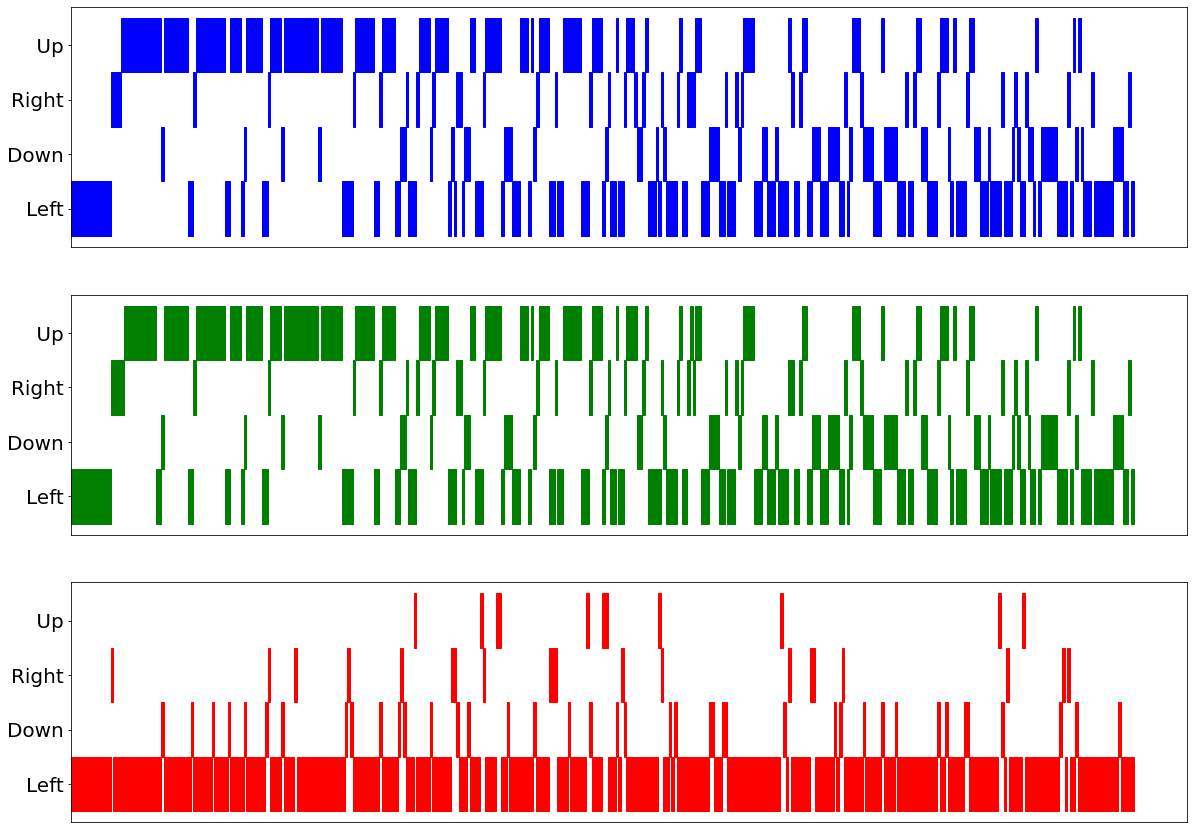

In [364]:
fig = plt.figure(figsize=(20, 15))
fig.tight_layout()

plt.subplot(3, 1, 1)
y = list(lake_val_iter_policy.values[0])
n = len(y)
x = list(range(n))
plt.barh(y, [1]*len(x), left=x, color = 'blue', edgecolor = 'blue', align='center', height=1)
plt.yticks([0,1, 2, 3], ['Left', 'Down', 'Right', ' Up'], fontsize= 20)
plt.xticks([])

plt.subplot(3, 1, 2)
y = list(lake_pol_iter_policy.values[0])
n = len(y)
x = list(range(n))
plt.barh(y, [1]*len(x), left=x, color = 'green', edgecolor = 'green', align='center', height=1)
plt.yticks([0,1, 2, 3], ['Left', 'Down', 'Right', ' Up'], fontsize= 20)
plt.xticks([])

plt.subplot(3, 1, 3)
y = list(lake_q_policy.values[0])
n = len(y)
x = list(range(n))
plt.barh(y, [1]*len(x), left=x, color = 'red', edgecolor = 'red', align='center', height=1)
plt.yticks([0,1, 2, 3], ['Left', 'Down', 'Right', ' Up'], fontsize= 20)
plt.xticks([])

plt.savefig('lake_opt_policy_actions.png')

([<matplotlib.axis.XTick at 0x1729074ef70>,
 [Text(0, 0, 'Left'),
  Text(1, 0, 'Down'),
  Text(2, 0, 'Right'),
  Text(3, 0, ' Up')])

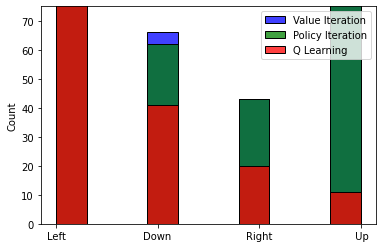

In [351]:
ax = sns.histplot(data=lake_val_iter_policy.values[0], color= 'blue', label = 'Value Iteration', legend=True)
ax = sns.histplot(data=lake_pol_iter_policy.values[0], color='green',label = 'Policy Iteration', legend=True)
ax = sns.histplot(data=lake_q_policy.values[0], color='red', label = 'Q Learning', legend=True)
ax.legend()
plt.ylim([0, 75])
plt.xticks([0,1, 2, 3], ['Left', 'Down', 'Right', ' Up'])
#plt.savefig('figs/nn_best_prob_hist.png', dpi=300)

In [393]:
print('Lake Value Iteration. Run Time:{0} for {1} iterations'.format(lake_val_iter_time, lake_val_iter_iters))
print('Lake Policy Iteration. Run Time:{0} for {1} iterations'.format(lake_pol_iter_time, lake_pol_iter_iters))
print('Lake Q Learning. Run Time:{0} for {1} iterations'.format(lake_q_time, lake_q_iters))

Lake Value Iteration. Run Time:0.01562809944152832 for 89 iterations
Lake Policy Iteration. Run Time:0.015538215637207031 for 91 iterations
Lake Q Learning. Run Time:1.8082244396209717 for 10000 iterations


## Main Scenarios - Forest Management

In [181]:
num_states = 2000
P_fm, R_fm = hiive.mdptoolbox.example.forest(S=num_states, p=0.01)

In [185]:
val_iters_fm = []

for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    for epsilon in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]:
        print('Running Gamma: {0}, Epsilon:{1}'.format(gamma, epsilon))
        val_iter = mdp.ValueIteration(P_fm, R_fm, gamma=gamma, epsilon=epsilon, max_iter=1000, initial_value=0, skip_check=False)
        val_iter.run()
        val_iters_fm.append(val_iter)

Running Gamma: 0.1, Epsilon:0.0001
Running Gamma: 0.1, Epsilon:0.001
Running Gamma: 0.1, Epsilon:0.01
Running Gamma: 0.1, Epsilon:0.1
Running Gamma: 0.1, Epsilon:0.2
Running Gamma: 0.1, Epsilon:0.3
Running Gamma: 0.2, Epsilon:0.0001
Running Gamma: 0.2, Epsilon:0.001
Running Gamma: 0.2, Epsilon:0.01
Running Gamma: 0.2, Epsilon:0.1
Running Gamma: 0.2, Epsilon:0.2
Running Gamma: 0.2, Epsilon:0.3
Running Gamma: 0.3, Epsilon:0.0001
Running Gamma: 0.3, Epsilon:0.001
Running Gamma: 0.3, Epsilon:0.01
Running Gamma: 0.3, Epsilon:0.1
Running Gamma: 0.3, Epsilon:0.2
Running Gamma: 0.3, Epsilon:0.3
Running Gamma: 0.4, Epsilon:0.0001
Running Gamma: 0.4, Epsilon:0.001
Running Gamma: 0.4, Epsilon:0.01
Running Gamma: 0.4, Epsilon:0.1
Running Gamma: 0.4, Epsilon:0.2
Running Gamma: 0.4, Epsilon:0.3
Running Gamma: 0.5, Epsilon:0.0001
Running Gamma: 0.5, Epsilon:0.001
Running Gamma: 0.5, Epsilon:0.01
Running Gamma: 0.5, Epsilon:0.1
Running Gamma: 0.5, Epsilon:0.2
Running Gamma: 0.5, Epsilon:0.3
Running Ga

In [193]:
fm_val_iter_df = get_val_iter_runs(val_iters_fm)
fm_val_iter_df.head()
fm_val_iter_df.to_csv('fm_val_iter_df.csv')

In [194]:
pol_iters_fm = []

for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    print('Running Gamma: {0}'.format(gamma))
    pol_iter = mdp.ValueIteration(P_fm, R_fm, gamma=gamma, skip_check=False)
    pol_iter.run()
    pol_iters_fm.append(pol_iter)

Running Gamma: 0.1
Running Gamma: 0.2
Running Gamma: 0.3
Running Gamma: 0.4
Running Gamma: 0.5
Running Gamma: 0.6
Running Gamma: 0.7
Running Gamma: 0.8
Running Gamma: 0.9
Running Gamma: 0.95
Running Gamma: 0.99


In [196]:
fm_pol_iter_df = get_pol_iter_runs(pol_iters_fm)
fm_pol_iter_df.to_csv('fm_pol_iter_df.csv')

In [199]:
gammas = [0.9, 0.95, 0.99]
alphas = [0.01, 0.1, 0.2]
alpha_decays = [0.75, 0.9, 0.99]
epsilons = [0.9, 0.99, 1]
epsilon_decays= [0.75, 0.9, 0.99]

n = len(gammas) * len(alphas) * len(alpha_decays)*len(epsilons)*len(epsilon_decays)
q_solvers_fm = []

for gamma in gammas:
    for alpha in alphas:
        for alpha_decay in alpha_decays:
            for epsilon in epsilons:
                for epsilon_decay in epsilon_decays:
                    print('{0}/{1}'.format(len(q_solvers_fm)+1,n))
                    q_solve = mdp.QLearning(P_fm, R_fm, gamma = gamma, alpha=alpha, alpha_decay=alpha_decay,
                                            epsilon=epsilon, epsilon_decay=epsilon_decay,  skip_check=True)
                    q_solve.run()
                    q_solvers_fm.append(q_solve)
                            

1/243
2/243
3/243
4/243
5/243
6/243
7/243
8/243
9/243
10/243
11/243
12/243
13/243
14/243
15/243
16/243
17/243
18/243
19/243
20/243
21/243
22/243
23/243
24/243
25/243
26/243
27/243
28/243
29/243
30/243
31/243
32/243
33/243
34/243
35/243
36/243
37/243
38/243
39/243
40/243
41/243
42/243
43/243
44/243
45/243
46/243
47/243
48/243
49/243
50/243
51/243
52/243
53/243
54/243
55/243
56/243
57/243
58/243
59/243
60/243
61/243
62/243
63/243
64/243
65/243
66/243
67/243
68/243
69/243
70/243
71/243
72/243
73/243
74/243
75/243
76/243
77/243
78/243
79/243
80/243
81/243
82/243
83/243
84/243
85/243
86/243
87/243
88/243
89/243
90/243
91/243
92/243
93/243
94/243
95/243
96/243
97/243
98/243
99/243
100/243
101/243
102/243
103/243
104/243
105/243
106/243
107/243
108/243
109/243
110/243
111/243
112/243
113/243
114/243
115/243
116/243
117/243
118/243
119/243
120/243
121/243
122/243
123/243
124/243
125/243
126/243
127/243
128/243
129/243
130/243
131/243
132/243
133/243
134/243
135/243
136/243
137/243
138/243
139/

In [246]:
fm_q_df = get_q_runs(q_solvers_fm)
fm_q_df.to_csv('fm_q_df.csv')

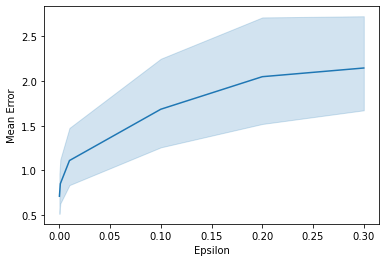

In [202]:
sns.lineplot(data = fm_val_iter_df, x ='Epsilon', y = 'Mean Error')
plt.savefig('fm_val_iter_eps_error.png')

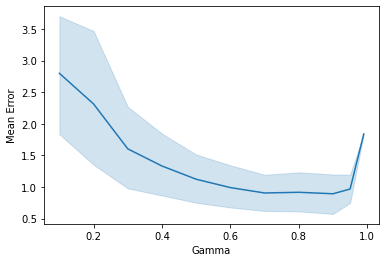

In [203]:
sns.lineplot(data = fm_val_iter_df, x ='Gamma', y = 'Mean Error')
plt.savefig('fm_val_iter_gamma_error.png')

In [376]:
fm_val_iter_eps = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Epsilon'].values[0]
fm_val_iter_gamma = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Gamma'].values[0]
fm_val_iter_policy = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Policy']
fm_val_iter_mean_value = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Mean Value']
fm_val_iter_max_value = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Max Value']
fm_val_iter_time = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Run Time'].values[0]
fm_val_iter_iters = fm_val_iter_df[fm_val_iter_df['Mean Error'] == fm_val_iter_df['Mean Error'].min()]['Number of Iterations'].values[0]
print('F.M. Value Iteration Optimal Model Epsilon:{0}, Gamma:{1}'.format(fm_val_iter_eps, fm_val_iter_gamma))

F.M. Value Iteration Optimal Model Epsilon:0.0001, Gamma:0.9


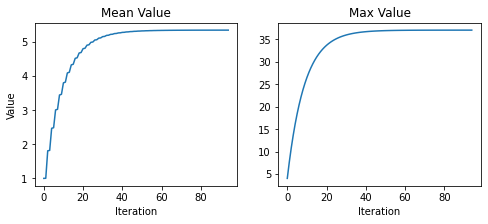

In [303]:
fig = plt.figure(figsize=(8, 3))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(fm_val_iter_mean_value.values[0], label = 'Mean Value')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean Value')

plt.subplot(1, 2, 2)
plt.plot(fm_val_iter_max_value.values[0], label = 'Max Value')
plt.xlabel('Iteration')

plt.title('Max Value')

plt.savefig('fm_val_iter_value.png')

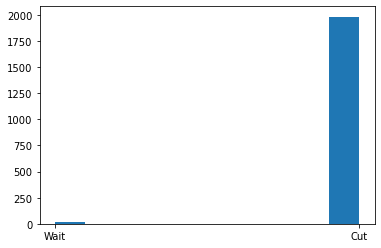

In [206]:
plt.hist(fm_val_iter_policy)
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['Wait', 'Cut'])
plt.savefig('fm_val_iter_policy.png')

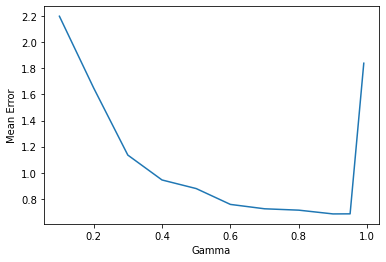

In [207]:
sns.lineplot(data = fm_pol_iter_df, x ='Gamma', y = 'Mean Error')
plt.savefig('fm_pol_iter_gamma_error.png')

In [377]:
fm_pol_iter_gamma = fm_pol_iter_df[fm_pol_iter_df['Mean Error'] == fm_pol_iter_df['Mean Error'].min()]['Gamma'].values[0]
fm_pol_iter_policy = fm_pol_iter_df[fm_pol_iter_df['Mean Error'] == fm_pol_iter_df['Mean Error'].min()]['Policy']
fm_pol_iter_mean_value = fm_pol_iter_df[fm_pol_iter_df['Mean Error'] == fm_pol_iter_df['Mean Error'].min()]['Mean Value']
fm_pol_iter_max_value = fm_pol_iter_df[fm_pol_iter_df['Mean Error'] == fm_pol_iter_df['Mean Error'].min()]['Max Value']
fm_pol_iter_time = fm_pol_iter_df[fm_pol_iter_df['Mean Error'] == fm_pol_iter_df['Mean Error'].min()]['Run Time'].values[0]
fm_pol_iter_iters = fm_pol_iter_df[fm_pol_iter_df['Mean Error'] == fm_pol_iter_df['Mean Error'].min()]['Number of Iterations'].values[0]

print('F.M. Policy Iteration Optimal Model Gamma:{0}'.format(fm_pol_iter_gamma))

F.M. Policy Iteration Optimal Model Gamma:0.9


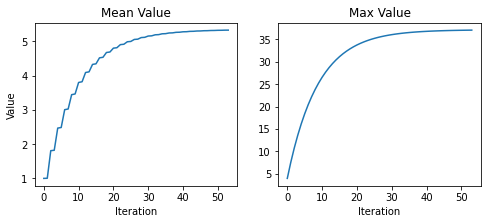

In [304]:
fig = plt.figure(figsize=(8, 3))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(fm_pol_iter_mean_value.values[0], label = 'Mean Value')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean Value')

plt.subplot(1, 2, 2)
plt.plot(fm_pol_iter_max_value.values[0], label = 'Max Value')
plt.xlabel('Iteration')

plt.title('Max Value')

plt.savefig('fm_pol_iter_value.png')

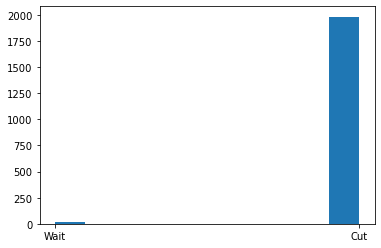

In [210]:
plt.hist(fm_pol_iter_policy)
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['Wait', 'Cut'])
plt.savefig('fm_pol_iter_policy.png')

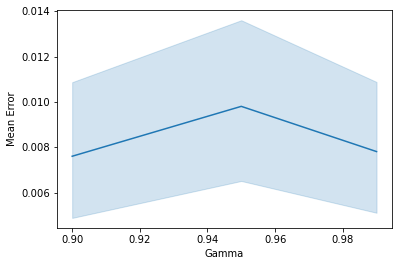

In [270]:
sns.lineplot(data = fm_q_df, x ='Gamma', y = 'Mean Error')
plt.savefig('fm_q_gamma_error.png')

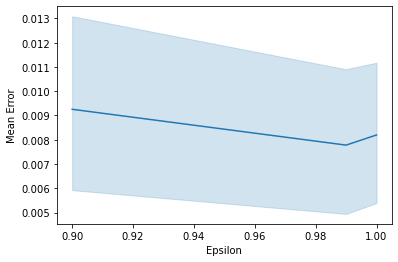

In [271]:
sns.lineplot(data = fm_q_df, x ='Epsilon', y = 'Mean Error')
plt.savefig('fm_q_eps_error.png')

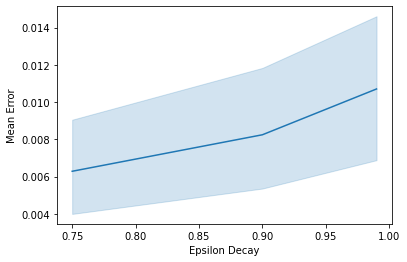

In [272]:
sns.lineplot(data = fm_q_df, x ='Epsilon Decay', y = 'Mean Error')
plt.savefig('fm_q_eps_decay_error.png')

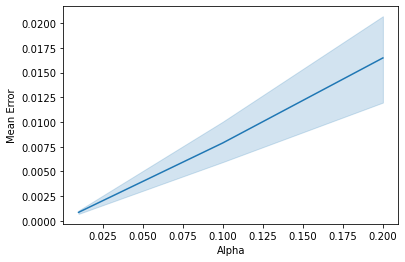

In [273]:
sns.lineplot(data = fm_q_df, x ='Alpha', y = 'Mean Error')
plt.savefig('fm_q_alpha_error.png')

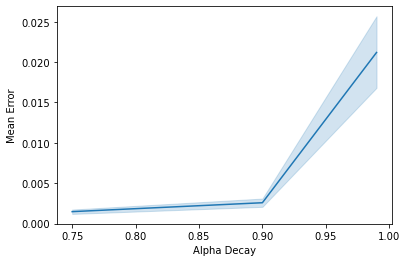

In [274]:
sns.lineplot(data = fm_q_df, x ='Alpha Decay', y = 'Mean Error')
plt.savefig('fm_q_alpha_decay_error.png')

In [385]:
fm_q_gamma = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Gamma'].values[0]
fm_q_eps = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Epsilon'].values[0]
fm_q_eps_decay = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Epsilon Decay'].values[0]
fm_q_alpha = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Alpha'].values[0]
fm_q_alpha_decay = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Alpha Decay'].values[0]

fm_q_policy = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Policy']
fm_q_mean_value = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Mean Value']
fm_q_max_value = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Max Value']

fm_q_time = fm_q_df[fm_q_df['Mean Error'] == fm_q_df['Mean Error'].min()]['Run Time'].values[0]
fm_q_iters = len(fm_q_max_value.values[0])

print('F.M. Q Learning Optimal Model Gamma:{0}, Epsilon:{1}, Eps. Decay:{2}, Alpha:{3}, Alpha Decay:{4}'.format(fm_q_gamma, fm_q_eps, fm_q_eps_decay, fm_q_alpha, fm_q_alpha_decay))

F.M. Q Learning Optimal Model Gamma:0.9, Epsilon:1.0, Eps. Decay:0.9, Alpha:0.2, Alpha Decay:0.99


10000

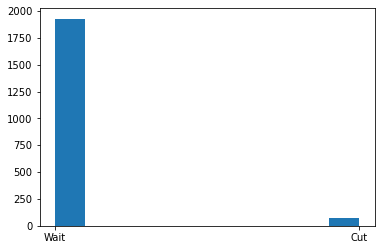

In [323]:
plt.hist(fm_q_policy)
ax = plt.gca()
ax.set_xticks([0,1])
ax.set_xticklabels(['Wait', 'Cut'])
plt.savefig('fm_q_policy_hist.png')

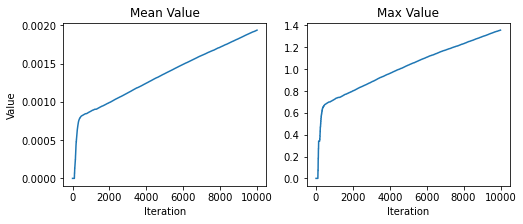

In [305]:
fig = plt.figure(figsize=(8, 3))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(fm_q_mean_value.values[0], label = 'Mean Value')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Mean Value')

plt.subplot(1, 2, 2)
plt.plot(fm_q_max_value.values[0], label = 'Max Value')
plt.xlabel('Iteration')

plt.title('Max Value')

plt.savefig('fm_q_value.png')

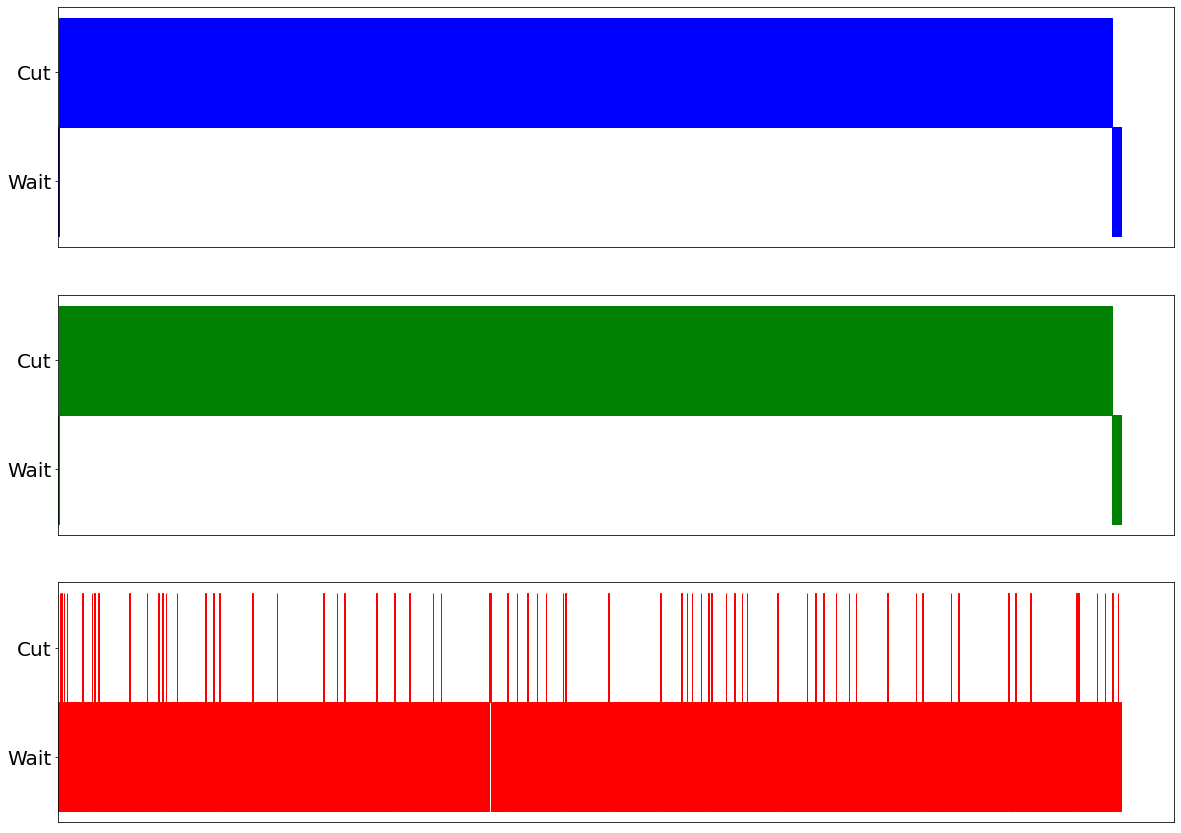

In [363]:
fig = plt.figure(figsize=(20, 15))
fig.tight_layout()

plt.subplot(3, 1, 1)
y = list(fm_val_iter_policy.values[0])
n = len(y)
x = list(range(n))
plt.barh(y, [1]*len(x), left=x, color = 'blue', edgecolor = 'blue', align='center', height=1)
plt.yticks([0,1], ['Wait', 'Cut'], fontsize= 20)
plt.xticks([])

plt.subplot(3, 1, 2)
y = list(fm_pol_iter_policy.values[0])
n = len(y)
x = list(range(n))
plt.barh(y, [1]*len(x), left=x, color = 'green', edgecolor = 'green', align='center', height=1)
plt.yticks([0,1], ['Wait', 'Cut'], fontsize= 20)
plt.xticks([])

plt.subplot(3, 1, 3)
y = list(fm_q_policy.values[0])
n = len(y)
x = list(range(n))
plt.barh(y, [1]*len(x), left=x, color = 'red', edgecolor = 'red', align='center', height=1)
plt.yticks([0,1], ['Wait', 'Cut'], fontsize= 20)
plt.xticks([])

plt.savefig('fm_opt_policy_actions.png')

In [386]:
print('FM Value Iteration. Run Time:{0} for {1} iterations'.format(fm_val_iter_time, fm_val_iter_iters))
print('FM Policy Iteration. Run Time:{0} for {1} iterations'.format(fm_pol_iter_time, fm_pol_iter_iters))
print('FM Q Learning. Run Time:{0} for {1} iterations'.format(fm_q_time, fm_q_iters))

FM Value Iteration. Run Time:0.6209080219268799 for 95 iterations
FM Policy Iteration. Run Time:0.2543613910675049 for 54 iterations
FM Q Learning. Run Time:1.8810884952545166 for 10000 iterations
